<a href="https://colab.research.google.com/github/briandk/2020-virtual-program-in-data-science/blob/master/museums.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [41]:
import pandas as pd

from plotnine import *

In [12]:
# We use `low_memory = False` because otherwise we get a warning that the data have mixed datatypes
museums = pd.read_csv("https://github.com/briandk/2020-virtual-program-in-data-science/raw/master/data/museums.csv", low_memory = False)

First let's get an overall look at the data

In [29]:
museums = museums.assign(
    state = museums[['State (Administrative Location)']]
)

museums

,Museum ID,Museum Name,Legal Name,Alternate Name,Museum Type,Institution Name,Street Address (Administrative Location),City (Administrative Location),State (Administrative Location),Zip Code (Administrative Location),Street Address (Physical Location),City (Physical Location),State (Physical Location),Zip Code (Physical Location),Phone Number,Latitude,Longitude,Locale Code (NCES),County Code (FIPS),State Code (FIPS),Region Code (AAM),Employer ID Number,Tax Period,Income,Revenue,state
0,8400200098,ALASKA AVIATION HERITAGE MUSEUM,ALASKA AVIATION HERITAGE MUSEUM,NaN,HISTORY MUSEUM,NaN,4721 AIRCRAFT DR,ANCHORAGE,AK,99502,NaN,NaN,NaN,NaN,9072485325,61.17925,-149.97254,1.0,20.0,2.0,6,920071852,201312.0,602912.0,550236.0,AK
1,8400200117,ALASKA BOTANICAL GARDEN,ALASKA BOTANICAL GARDEN INC,NaN,"ARBORETUM, BOTANICAL GARDEN, OR NATURE CENTER",NaN,4601 CAMPBELL AIRSTRIP RD,ANCHORAGE,AK,99507,NaN,NaN,NaN,NaN,9077703692,61.16890,-149.76708,4.0,20.0,2.0,6,920115504,201312.0,1379576.0,1323742.0,AK
2,8400200153,ALASKA CHALLENGER CENTER FOR SPACE SCIENCE TEC...,ALASKA CHALLENGER CENTER FOR SPACE SCIENCE TEC...,NaN,SCIENCE & TECHNOLOGY MUSEUM OR PLANETARIUM,NaN,9711 KENAI SPUR HWY,KENAI,AK,99611,NaN,NaN,NaN,NaN,9072832000,60.56149,-151.21598,3.0,122.0,2.0,6,921761906,201312.0,740030.0,729080.0,AK
3,8400200143,ALASKA EDUCATORS HISTORICAL SOCIETY,ALASKA EDUCATORS HISTORICAL SOCIETY,NaN,HISTORIC PRESERVATION,NaN,214 BIRCH STREET,KENAI,AK,99611,NaN,NaN,NaN,NaN,2142472478,60.56280,-151.26597,3.0,122.0,2.0,6,920165178,201412.0,0.0,0.0,AK
4,8400200027,ALASKA HERITAGE MUSEUM,ALASKA AVIATION HERITAGE MUSEUM,NaN,HISTORY MUSEUM,NaN,301 W NORTHERN LIGHTS BLVD,ANCHORAGE,AK,99503,NaN,NaN,NaN,NaN,9072652834,61.17925,-149.97254,1.0,20.0,2.0,6,920071852,201312.0,602912.0,550236.0,AK
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33067,8405600184,WYOMING STATE HISTORICAL SOCIETY,WYOMING STATE HISTORICAL SOCIETY,NaN,HISTORIC PRESERVATION,NaN,PO BOX 73,SHERIDAN,WY,82801,850 SIBLEY CIR,SHERIDAN,WY,82801.0,3076751150,44.82345,-106.87592,4.0,33.0,56.0,5,836007540,NaN,NaN,NaN,WY
33068,8405600061,WYOMING STATE MUSEUM,WYOMING STATE MUSEUM VOLUNTEERS INC,NaN,GENERAL MUSEUM,NaN,2301 CENTRAL AVENUE,CHEYENNE,WY,82001,2301 CENTRAL AVENUE,CHEYENNE,WY,82001.0,3077777022,41.13941,-104.81813,1.0,21.0,56.0,5,237368629,201404.0,0.0,0.0,WY
33069,8405600158,WYOMING TERRITORIAL PARK HISTORIC ASSOCIATION,WYOMING TERRITORIAL PARK HISTORIC ASSOCIATION INC,NaN,HISTORIC PRESERVATION,NaN,1273 N 15TH ST STE 121,LARAMIE,WY,82072,NaN,NaN,NaN,NaN,NaN,41.32276,-105.57686,3.0,1.0,56.0,5,830318392,201312.0,208508.0,83981.0,WY
33070,8405600137,WYOMING TRANSPORTATION MUSEUM,WYOMING TRANSPORTATION MUSEUM CORP,NaN,HISTORY MUSEUM,NaN,PO BOX 704,CHEYENNE,WY,82003,121 W 15TH ST SUITE 300,CHEYENNE,WY,82003.0,3076323905,41.13010,-104.81916,1.0,21.0,56.0,5,830295570,201309.0,0.0,0.0,WY


How do the museums break down by type?

In [14]:
museums[['Museum Type']].describe()

,Museum Type
count,33072
unique,9
top,HISTORIC PRESERVATION
freq,14861


In [15]:
museums['Museum Type'].value_counts()

HISTORIC PRESERVATION                            14861
GENERAL MUSEUM                                    8699
ART MUSEUM                                        3241
HISTORY MUSEUM                                    2284
ARBORETUM, BOTANICAL GARDEN, OR NATURE CENTER     1484
SCIENCE & TECHNOLOGY MUSEUM OR PLANETARIUM        1081
ZOO, AQUARIUM, OR WILDLIFE CONSERVATION            564
CHILDREN'S MUSEUM                                  512
NATURAL HISTORY MUSEUM                             346
Name: Museum Type, dtype: int64

How many museums are there in each state?

In [23]:
museums[['state', 'Museum ID']].groupby('state').count().sort_values(by = 'Museum ID', ascending = False).head()

,Museum ID
state,
CA,2670
NY,2239
TX,1886
PA,1653
OH,1363


Interesting. I would not have predicted Ohio would be 5th.

Next, let's take a look at revenue and taxes. First, we'll compute the total number of distinct tax periods represented by these records.

In [37]:
museums.groupby('Tax Period').count().sort_values('Museum ID', ascending = False)

,Museum ID,Museum Name,Legal Name,Alternate Name,Museum Type,Institution Name,Street Address (Administrative Location),City (Administrative Location),State (Administrative Location),Zip Code (Administrative Location),Street Address (Physical Location),City (Physical Location),State (Physical Location),Zip Code (Physical Location),Phone Number,Latitude,Longitude,Locale Code (NCES),County Code (FIPS),State Code (FIPS),Region Code (AAM),Employer ID Number,Income,Revenue,state
Tax Period,,,,,,,,,,,,,,,,,,,,,,,,,
201312.0,10157,10157,10157,776,10157,4,10157,10157,10157,10157,3301,3304,3304,3303,7337,10144,10144,10142,9401,10157,10157,10157,10152,9679,10157
201412.0,4683,4683,4683,139,4683,0,4683,4683,4683,4683,1441,1441,1441,1441,2645,4680,4680,4680,4321,4683,4683,4682,4683,4653,4683
201406.0,2577,2577,2577,257,2577,302,2577,2577,2577,2577,707,708,708,708,1958,2576,2576,2576,2420,2577,2577,2577,2536,2503,2577
201306.0,1343,1343,1343,135,1343,675,1343,1343,1343,1343,189,189,189,189,1015,1339,1339,1339,1293,1343,1343,1343,1152,1139,1343
201409.0,616,616,616,49,616,2,616,616,616,616,216,216,216,216,462,615,615,615,581,616,616,616,616,607,616
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
200512.0,1,1,1,0,1,0,1,1,1,1,0,0,0,0,1,1,1,1,1,1,1,1,1,0,1
200506.0,1,1,1,0,1,1,1,1,1,1,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1
200412.0,1,1,1,0,1,0,1,1,1,1,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1


The total number of tax periods is important, because our data are actually wider than it seems at first. Each museum might be duplicated in the dataset for every tax period where we have information on it. So, it's possible we're not dealing with ~ 33,000 museums, but rather a much smaller amount with repeated data for each tax period. 

That repetition means our earlier questions of "how many museums are there in each state?" might be off, and we should try recomputing them.

In [33]:
museums[['Museum Name', 'Museum ID']].groupby('Museum ID').count()

,Museum Name
Museum ID,
8400100001,1
8400100002,1
8400100004,1
8400100005,1
8400100007,1
...,...
8409504380,1
8409504381,1
8409504382,1


Huh. That's funny. It would appear that every row of the dataset specifies a unique museum. I wonder whether we can pick a museum at random and see whether it repeats.

In [34]:
museums[museums['Museum Name'] == "ALASKA HERITAGE MUSEUM"]

,Museum ID,Museum Name,Legal Name,Alternate Name,Museum Type,Institution Name,Street Address (Administrative Location),City (Administrative Location),State (Administrative Location),Zip Code (Administrative Location),Street Address (Physical Location),City (Physical Location),State (Physical Location),Zip Code (Physical Location),Phone Number,Latitude,Longitude,Locale Code (NCES),County Code (FIPS),State Code (FIPS),Region Code (AAM),Employer ID Number,Tax Period,Income,Revenue,state
4,8400200027,ALASKA HERITAGE MUSEUM,ALASKA AVIATION HERITAGE MUSEUM,NaN,HISTORY MUSEUM,NaN,301 W NORTHERN LIGHTS BLVD,ANCHORAGE,AK,99503,NaN,NaN,NaN,NaN,9072652834,61.17925,-149.97254,1.0,20.0,2.0,6,920071852,201312.0,602912.0,550236.0,AK


So, at the very least the Alaska Heritage Museum only appears once.

What happens if we look at the distribution of revenue for the tax period with the most data?

/usr/local/lib/python3.6/dist-packages/plotnine/layer.py:360: PlotnineWarning: stat_density : Removed 478 rows containing non-finite values.
  data = self.stat.compute_layer(data, params, layout)


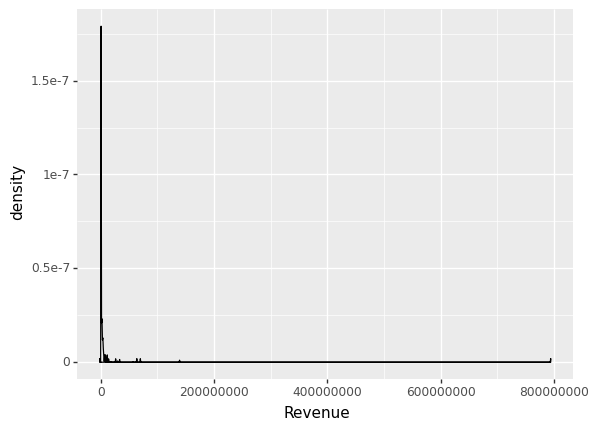

<ggplot: (-9223363242633199251)>

In [46]:
museums_2013_december = museums[museums['Tax Period'] == 201312.0]

(
    ggplot(
        aes(
          x = 'Revenue'
        ),
        data = museums_2013_december
    ) +
    geom_density()
)

☝️ Well, that graph looks pretty blown out. Something is on the extreme high end of revenue, unlike most of the other museums. Let's see if we can figure out what's going on.

In [47]:
museums_2013_december['Revenue'].describe()

count    9.679000e+03
mean     7.532145e+05
std      1.043294e+07
min     -1.799709e+06
25%      0.000000e+00
50%      3.354000e+04
75%      1.693055e+05
max      7.939540e+08
Name: Revenue, dtype: float64

☝️ Well that's interesting. The data description is telling us at least three things:

- 75% of the data is on the order of 10^5 dollars, or about some multiple of \$10,000
- The worst-performing museum actually seems to have had a loss on the order of \$100,000 or more
- The best-performing museum raked in almost \$800,000,000

That helps the plot make more sense. Most of the museums are making sub-million-dollar revenue, except for some of the ones at the top, one of which is making a thousand times more than that (more or less).

In [49]:
million_dollar_museums = museums_2013_december[museums_2013_december['Revenue'] > 1000000]

million_dollar_museums.sort_values('Revenue', ascending = False)

,Museum ID,Museum Name,Legal Name,Alternate Name,Museum Type,Institution Name,Street Address (Administrative Location),City (Administrative Location),State (Administrative Location),Zip Code (Administrative Location),Street Address (Physical Location),City (Physical Location),State (Physical Location),Zip Code (Physical Location),Phone Number,Latitude,Longitude,Locale Code (NCES),County Code (FIPS),State Code (FIPS),Region Code (AAM),Employer ID Number,Tax Period,Income,Revenue,state
5353,8401100201,NATIONAL ACADEMY OF SCIENCES,NATIONAL ACADEMY OF SCIENCES,NaN,SCIENCE & TECHNOLOGY MUSEUM OR PLANETARIUM,NaN,2101 CONSTITUTION AVE N,WASHINGTON,DC,20418,NaN,NaN,NaN,NaN,2023342000,38.89294,-77.04770,1.0,1.0,11.0,2,530196932,201312.0,1.009427e+09,793953993.0,DC
5358,8401100033,NATIONAL GEOGRAPHIC MUSEUM,NATIONAL GEOGRAPHIC SOCIETY,NaN,GENERAL MUSEUM,NaN,1145 17TH ST NW,WASHINGTON,DC,20036,NaN,NaN,NaN,NaN,2028577588,38.90514,-77.03810,1.0,1.0,11.0,2,530193519,201312.0,6.859120e+08,529780148.0,DC
29956,8405100584,COLONIAL WILLIAMSBURG,COLONIAL WILLIAMSBURG FOUNDATION,NaN,HISTORIC PRESERVATION,NaN,PO BOX 1776,WILLIAMSBURG,VA,23187,310 SOUTH ENGLAND STREET,WILLIAMSBURG,VA,23187.0,7572207670,37.26960,-76.69983,2.0,830.0,51.0,3,540505888,201312.0,4.629071e+08,139016488.0,VA
2840,8400602286,MONTEREY BAY AQUARIUM,MONTEREY BAY AQUARIUM FOUNDATION,NaN,"ZOO, AQUARIUM, OR WILDLIFE CONSERVATION",NaN,886 CANNERY ROW,MONTEREY,CA,93940,NaN,NaN,NaN,NaN,8316484800,36.61784,-121.90177,2.0,53.0,6.0,6,942487469,201312.0,1.374917e+08,86558017.0,CA
21401,8403602218,NATIONAL SEPTEMBER 11 MEMORIAL & MUSEUM,NATL SEPT 11 MEMORIAL AND MUSEUM AT THE WORLD ...,NaN,HISTORY MUSEUM,NaN,180 GREENWICH STREET,NEW YORK,NY,10007,180 GREENWICH STREET,NEW YORK,NY,10007.0,2122665211,40.71441,-74.00950,1.0,61.0,36.0,2,383678458,201312.0,8.776695e+07,82803579.0,NY
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10413,8401800752,WESSELMAN NATURE SOCIETY,WESSELMAN PARK NATURE SOCIETY INC,NaN,"ARBORETUM, BOTANICAL GARDEN, OR NATURE CENTER",NaN,551 N BOEKE RD,EVANSVILLE,IN,47711,551 N BOEKE RD,EVANSVILLE,IN,47711.0,8124790771,37.98359,-87.52005,1.0,163.0,18.0,4,237193105,201312.0,1.041875e+06,1018286.0,IN
29912,8405100819,CENTRAL VIRGINIA BATTLEFIELDS TRUST,CENTRAL VIRGINIA BATTLEFIELDS TRUST INC,NaN,HISTORIC PRESERVATION,NaN,PO BOX 3417,FREDERICKSBRG,VA,22402,2217 PRINCESS ANNE ST,FREDERICKSBRG,VA,22402.0,5403740900,38.31394,-77.46888,2.0,630.0,51.0,3,541828344,201312.0,1.015840e+06,1014462.0,VA
24854,8404201597,BRANDYWINE VALLEY ASSOCIATION,BRANDYWINE VALLEY ASSOCIATION INC,NaN,"ARBORETUM, BOTANICAL GARDEN, OR NATURE CENTER",NaN,1760 WAWASET RD,WEST CHESTER,PA,19382,NaN,NaN,NaN,NaN,NaN,39.91344,-75.67828,4.0,29.0,42.0,2,510058593,201312.0,1.042866e+06,1007679.0,PA
10382,8401800338,UNITED WAY OF GREATER LA PORTE COUNTY,UNITED WAY OF GREATER LAPORTE COUNTY INC,NaN,SCIENCE & TECHNOLOGY MUSEUM OR PLANETARIUM,NaN,115 E 4TH ST,MICHIGAN CITY,IN,46350,NaN,NaN,NaN,NaN,2192103534,41.71833,-86.90216,1.0,91.0,18.0,4,350782893,201312.0,1.050006e+06,1005698.0,IN
